In [1]:
import re

from wordcloud import WordCloud
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import (
    feature_extraction,
    linear_model,
    model_selection,
    preprocessing,
    cluster,
)

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) #pour wordcloud

In [3]:
import p5_nlp_utils

/opt/conda/lib/python3.7/site-packages/past/types/oldstr.py:36: DeprecationWarning: invalid escape sequence \d
  """
/opt/conda/lib/python3.7/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:585: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.object,
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:627: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Dep

https://spacy.io/usage#quickstart
https://www.kaggle.com/code/rftexas/nlp-cheatsheet-master-nlp
https://www.kaggle.com/code/philculliton/nlp-getting-started-tutorial/notebook

In [4]:
pip install jupyter-black jupyter

Note: you may need to restart the kernel to use updated packages.


In [5]:
# for black formating
import jupyter_black  # pip install jupyter-black jupyter

jupyter_black.load()
# ??jupyter_black.load #show config

```sql
SELECT TOP 1000000 Title, Body, Tags, Id, Score, ViewCount, FavoriteCount, AnswerCount, CommentCount, ClosedDate, AcceptedAnswerId
FROM Posts
WHERE ViewCount>100 AND (LEN(TAGS)-LEN(REPLACE(Tags, '<','')))>=5
```
only get 500000

In [6]:
df = pd.read_csv("/kaggle/input/stackoverflowqueryres0/QueryResults.csv")

```sql
SELECT TOP 500000 Title, Body, Tags, Id, Score, ViewCount, FavoriteCount, AnswerCount, CommentCount, ClosedDate, AcceptedAnswerId
FROM Posts
WHERE ViewCount>1000 AND Score>10 AND (AnswerCount>5 OR CommentCount>5) AND (LEN(TAGS)-LEN(REPLACE(Tags, '<','')))>=4
```

In [7]:
df = pd.concat([pd.read_csv("/kaggle/input/stackoverflow/QueryResults1Score.csv"), df])

```sql
SELECT TOP 500000 Title, Body, Tags, Id, Score, ViewCount, FavoriteCount, AnswerCount, CommentCount, ClosedDate, AcceptedAnswerId
FROM Posts
WHERE ViewCount>1000 AND Score>10 AND (AnswerCount>5 OR CommentCount>5) AND (LEN(TAGS)-LEN(REPLACE(Tags, '<','')))>=4
ORDER BY Score Desc, ViewCount DESC
```

In [8]:
df = pd.concat(
    [pd.read_csv("/kaggle/input/stackoverflow/QueryResults2TopOrderByScore.csv"), df]
)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Title             150000 non-null  object 
 1   Body              150000 non-null  object 
 2   Tags              150000 non-null  object 
 3   Id                150000 non-null  int64  
 4   Score             150000 non-null  int64  
 5   ViewCount         150000 non-null  int64  
 6   FavoriteCount     116783 non-null  float64
 7   AnswerCount       150000 non-null  int64  
 8   CommentCount      150000 non-null  int64  
 9   ClosedDate        7619 non-null    object 
 10  AcceptedAnswerId  107891 non-null  float64
dtypes: float64(2), int64(5), object(4)
memory usage: 13.7+ MB


In [10]:
df = df[~df.duplicated(subset="Id")].reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118442 entries, 0 to 118441
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Title             118442 non-null  object 
 1   Body              118442 non-null  object 
 2   Tags              118442 non-null  object 
 3   Id                118442 non-null  int64  
 4   Score             118442 non-null  int64  
 5   ViewCount         118442 non-null  int64  
 6   FavoriteCount     85312 non-null   float64
 7   AnswerCount       118442 non-null  int64  
 8   CommentCount      118442 non-null  int64  
 9   ClosedDate        5445 non-null    object 
 10  AcceptedAnswerId  81953 non-null   float64
dtypes: float64(2), int64(5), object(4)
memory usage: 9.9+ MB


### combinaison de tags les plus fréquent

In [11]:
df["Tags"].value_counts(normalize=True).head(20)

<javascript><jquery><html><css>                             0.000912
<javascript><jquery><html><css><twitter-bootstrap>          0.000735
<javascript><php><jquery><html><ajax>                       0.000321
<sql><sql-server><sql-server-2005><tsql>                    0.000270
<html><css><twitter-bootstrap><twitter-bootstrap-3>         0.000220
<javascript><php><jquery><html><css>                        0.000203
<sql><sql-server><tsql><sql-server-2008>                    0.000194
<javascript><jquery><html><css><jquery-ui>                  0.000177
<javascript><php><jquery><mysql><ajax>                      0.000160
<c#><.net><winforms><datagridview>                          0.000144
<java><lambda><java-8><java-stream>                         0.000144
<javascript><jquery><html><forms>                           0.000135
<php><apache><.htaccess><redirect><mod-rewrite>             0.000127
<c#><.net><exception><exception-handling>                   0.000127
<android><android-studio><gradle><

In [12]:
tags = df["Tags"].str.extractall(r"\<([^>]*)\>")
tags

0
       match                    
0      0                    java
       1                     c++
       2             performance
       3        cpu-architecture
       4       branch-prediction
...                          ...
118441 0                      c#
       1                    .net
       2      garbage-collection
       3                 dispose
       4             idisposable

[550206 rows x 1 columns]

## Proportion de chaque tag

In [13]:
tags.value_counts(normalize=True).head(50) * 100 * (
    len(tags) / len(df)
)  # pour avoir prop

java              12.043025
c#                11.783827
javascript        11.657182
python             8.665845
android            6.974722
c++                6.633627
ios                6.242718
html               5.870384
php                5.540264
.net               5.331724
jquery             5.319059
css                3.783286
objective-c        3.059725
c                  3.055504
sql                2.984583
iphone             2.774354
asp.net            2.726229
mysql              2.357272
linux              2.331943
node.js            2.293105
arrays             2.093008
swift              2.049948
sql-server         1.968896
json               1.949477
string             1.882778
windows            1.827899
performance        1.827055
ruby-on-rails      1.714763
xcode              1.713919
spring             1.669171
ajax               1.523108
database           1.500312
asp.net-mvc        1.467385
algorithm          1.386333
ruby               1.354249
macos              1

In [14]:
print(
    f"les 50tags les plus fréquent représente {tags.value_counts(normalize=True).head(50).sum():.2%} des données"
)

les 50tags les plus fréquent représente 33.29% des données


## tags les plus fréquents:
### langage : 
- javascript(jquery, nodejs, angularjs,reactjs,angular)
- c# (.net, asp.net, asp.net-mvc, wpf) 
- java (spring, eclipse ou catégorie ide)
- python (django
- html css xml json ajax forms image (=front?)
- c (objective-c 
- database sql (mysql, sql-server ) (hybernate?)
- ? ruby ruby-on-rails,
- swift
### OS
- android
- ios iphone macos
- linux
- windows

### Notion divers (ni langage ni os)
- arrays string 
- performance multithreading
- unit-testing


In [15]:
tags

0
       match                    
0      0                    java
       1                     c++
       2             performance
       3        cpu-architecture
       4       branch-prediction
...                          ...
118441 0                      c#
       1                    .net
       2      garbage-collection
       3                 dispose
       4             idisposable

[550206 rows x 1 columns]

In [16]:
tags.unstack()[0]

match,0,1,2,3,4,5
0,java,c++,performance,cpu-architecture,branch-prediction,NaN
1,git,version-control,git-commit,undo,NaN,NaN
2,git,version-control,git-branch,git-push,git-remote,NaN
3,git,version-control,git-pull,git-fetch,NaN,NaN
4,c++,c,operators,code-formatting,standards-compliance,NaN
...,...,...,...,...,...,...
118437,iphone,ios,objective-c,nsstring,core-text,NaN
118438,google-maps,android-fragments,xamarin.android,google-maps-android-api-2,android-2.2-froyo,NaN
118439,javascript,google-maps,google-maps-api-3,internet-explorer-8,google-maps-markers,NaN
118440,java,email,exchange-server,jakarta-mail,ntlm,NaN


In [17]:
df = df.join(tags.unstack()[0])
df.head()

,Title,Body,Tags,Id,Score,ViewCount,FavoriteCount,AnswerCount,CommentCount,ClosedDate,AcceptedAnswerId,0,1,2,3,4,5
0,Why is processing a sorted array faster than p...,<p>Here is a piece of C++ code that shows some...,<java><c++><performance><cpu-architecture><bra...,11227809,26730,1769357,0.0,27,9,NaN,11227902.0,java,c++,performance,cpu-architecture,branch-prediction,NaN
1,How do I undo the most recent local commits in...,<p>I accidentally committed the wrong files to...,<git><version-control><git-commit><undo>,927358,25054,11955812,2.0,100,12,NaN,927386.0,git,version-control,git-commit,undo,NaN,NaN
2,How do I delete a Git branch locally and remot...,<h4>Failed Attempts to Delete a Remote Branch:...,<git><version-control><git-branch><git-push><g...,2003505,19720,10488243,0.0,41,10,NaN,2003515.0,git,version-control,git-branch,git-push,git-remote,NaN
3,What is the difference between 'git pull' and ...,"<p>What are the differences between <a href=""h...",<git><version-control><git-pull><git-fetch>,292357,13439,3286583,0.0,37,7,NaN,292359.0,git,version-control,git-pull,git-fetch,NaN,NaN
4,"What is the ""-->"" operator in C++?","<p>After reading <a href=""http://groups.google...",<c++><c><operators><code-formatting><standards...,1642028,9903,949071,0.0,28,0,NaN,1642035.0,c++,c,operators,code-formatting,standards-compliance,NaN


In [18]:
print(
    f"{sum(df[5].isna())} sans 6éme tag sur {df.shape[0]} ({sum(df[5].isna())/df.shape[0]:.2%})"
)
print(
    f"{sum(df[4].isna())} sans 6éme tag sur {df.shape[0]} ({sum(df[4].isna())/df.shape[0]:.2%})"
)

118438 sans 6éme tag sur 118442 (100.00%)
42008 sans 6éme tag sur 118442 (35.47%)


In [19]:
df[~df[5].isna()][["Title", "Body", 0, 1, 2, 3, 4, 5]]

,Title,Body,0,1,2,3,4,5
94452,Show the latest commit value within a web appl...,<p>I have a few Rails applications and I use G...,ruby-on-rails,git,version-control,github,amazon-elastic-beanstalk,beanstalk-svn
95832,Remove genres android-UniversalMusicPlayer-master,"<p>I am using ""android-UniversalMusicPlayer-ma...",android,android-studio,github,mobile-application,audio-player,android-music-player
104180,How To Add Media To MediaStore on Android 4.4 ...,"<p>Background: In Android 4.4, Google decided ...",android,android-sdcard,android-4.4-kitkat,audio-player,android-mediascanner,android-music-player
108913,When handling a form POST in a Django views.py...,<p>I have a Django application that generates ...,python,django,csv,httpresponse,forms,http-post


# Nettoyage du texte

In [20]:
def words_cloud(data, stopwords=[]):
    plt.figure(figsize=(20, 15))
    wordcloud = WordCloud(
        background_color="white", stopwords=stopwords, max_words=50
    ).generate(data.to_string(header=False, index=False))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()


# words_cloud(df["Body_nohtml_bow"])

/opt/conda/lib/python3.7/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/conda/lib/python3.7/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/conda/lib/python3.7/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/conda/lib/python3.7/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/opt/conda/lib/python

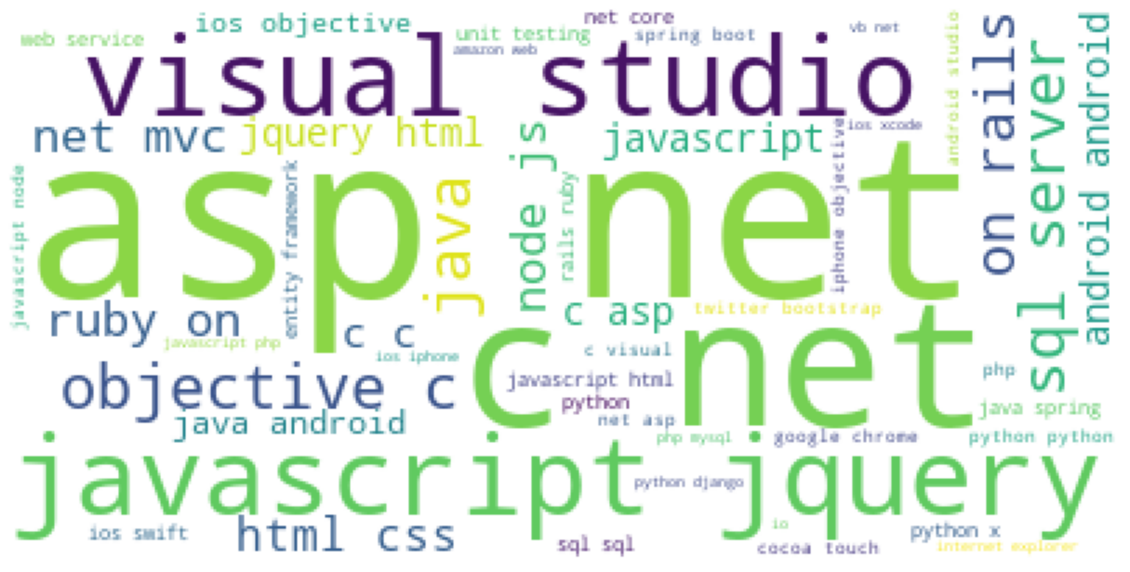

In [21]:
words_cloud(df[[0, 1, 2, 3, 4, 5]], stopwords=["Nan"])

In [22]:
def tag_is_in(df: pd.DataFrame(), tag: str, nb_cols: int = 6):
    return eval("|".join(f'(df[{i}] == "{tag}")' for i in range(0, nb_cols)))


tag_is_in(df, "javascript")

0         False
1         False
2         False
3         False
4         False
          ...  
118437    False
118438    False
118439     True
118440    False
118441    False
Length: 118442, dtype: bool

In [23]:
print(
    f'{sum(tag_is_in(df, "javascript"))} js ({(sum(tag_is_in(df, "javascript"))/ len(df)):.2%})'
)

13807 js (11.66%)


In [24]:
import spacy
from bs4 import BeautifulSoup

nlp = spacy.load("en_core_web_sm")

In [25]:
def nlp_print(phrase: str):
    doc = nlp(phrase)
    print(
        f"Token \t\tLemma \t\tStopword\t\tPartOfSpeech".format(
            "Token", "Lemma", "Stopword", "PartOfSpeech"
        )
    )
    print("-" * 60)
    for token in doc:
        print(
            f"{token.text}\t\t{token.lemma_}\t\t{token.is_stop} \t\t {token.pos_,}"
        )  # token.shape_, token.is_alpha, token.tag_,
    return doc


for index in range(0, 3):
    nlp_print(df["Title"][index])

Token 		Lemma 		Stopword		PartOfSpeech
------------------------------------------------------------
Why		why		True 		 ('SCONJ',)
is		be		True 		 ('AUX',)
processing		process		False 		 ('VERB',)
a		a		True 		 ('DET',)
sorted		sorted		False 		 ('ADJ',)
array		array		False 		 ('NOUN',)
faster		fast		False 		 ('ADV',)
than		than		True 		 ('ADP',)
processing		process		False 		 ('VERB',)
an		an		True 		 ('DET',)
unsorted		unsorted		False 		 ('ADJ',)
array		array		False 		 ('NOUN',)
?		?		False 		 ('PUNCT',)
Token 		Lemma 		Stopword		PartOfSpeech
------------------------------------------------------------
How		how		True 		 ('SCONJ',)
do		do		True 		 ('AUX',)
I		I		True 		 ('PRON',)
undo		undo		False 		 ('VERB',)
the		the		True 		 ('DET',)
most		most		True 		 ('ADV',)
recent		recent		False 		 ('ADJ',)
local		local		False 		 ('ADJ',)
commits		commit		False 		 ('NOUN',)
in		in		True 		 ('ADP',)
Git		Git		False 		 ('PROPN',)
?		?		False 		 ('PUNCT',)
Token 		Lemma 		Stopword		PartOfSpeech
------

In [26]:
nlp_print(df["Title"][11])

Token 		Lemma 		Stopword		PartOfSpeech
------------------------------------------------------------
How		how		True 		 ('SCONJ',)
do		do		True 		 ('AUX',)
JavaScript		JavaScript		False 		 ('PROPN',)
closures		closure		False 		 ('NOUN',)
work		work		False 		 ('VERB',)
?		?		False 		 ('PUNCT',)


How do JavaScript closures work?

In [27]:
df_clean = p5_nlp_utils.TextCleaning.cleaning_v2(df)
df_clean

[=====================================================================] 100% 0s


,Id,Title,Body,0,1,2,3,4,5,Token_lemma,Token_BERT,code
0,11227809,Why is processing a sorted array faster than p...,<p>Here is a piece of C++ code that shows some...,java,c++,performance,cpu-architecture,branch-prediction,NaN,process array process array piece c++ code sho...,why is processing a sorted array faster than p...,#include <algorithm>\n#include <ctime>\n#inclu...
1,927358,How do I undo the most recent local commits in...,<p>I accidentally committed the wrong files to...,git,version-control,git-commit,undo,NaN,NaN,undo commit git commit file git push commit se...,how do i undo the most recent local commits in...,
2,2003505,How do I delete a Git branch locally and remot...,<h4>Failed Attempts to Delete a Remote Branch:...,git,version-control,git-branch,git-push,git-remote,NaN,delete git branch delete remote origin bugfix ...,how do i delete a git branch locally and remot...,$ git branch -d remotes/origin/bugfix\nerror: ...
3,292357,What is the difference between 'git pull' and ...,"<p>What are the differences between <a href=""h...",git,version-control,git-pull,git-fetch,NaN,NaN,difference git pull git fetch difference git p...,what is the difference between 'git pull' and ...,git pull git fetch
4,1642028,"What is the ""-->"" operator in C++?","<p>After reading <a href=""http://groups.google...",c++,c,operators,code-formatting,standards-compliance,NaN,operator c++ read hidden features dark corners...,"what is the ""-->"" operator in c++? after readi...",comp.lang.c++.moderated #include <stdio.h>\nin...
...,...,...,...,...,...,...,...,...,...,...,...,...
118437,19076229,NSString boundingRectWithSize cutting height s...,<p>I have a custom UIView which is drawing an ...,iphone,ios,objective-c,nsstring,core-text,NaN,nsstring boundingrectwithsize cut height coret...,nsstring boundingrectwithsize cutting height s...,- (NSMutableAttributedString *)getAttributedSt...
118438,19076240,MvxBind:Error - View type not found - fragment,<p>I'm trying to add map as a part of my activ...,google-maps,android-fragments,xamarin.android,google-maps-android-api-2,android-2.2-froyo,NaN,mvxbind error view type find fragment try add ...,mvxbind:error - view type not found - fragment...,"<fragment\n android:id=""@+id/map""\..."
118439,19076261,Markers not showing in ie 8,<p>I have created a Google Maps application wh...,javascript,google-maps,google-maps-api-3,internet-explorer-8,google-maps-markers,NaN,marker show ie create google maps application ...,markers not showing in ie 8 i have created a g...,var map;\n function initialize() { \n ...
118440,19076270,JAVAMAIL : AUTH NTLM failed,<p>i try to send email with java in local netw...,java,email,exchange-server,jakarta-mail,ntlm,NaN,javamail ntlm fail try send email java network...,javamail : auth ntlm failed i try to send emai...,import java.io.UnsupportedEncodingException;\n...


/opt/conda/lib/python3.7/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/conda/lib/python3.7/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/opt/conda/lib/python3.7/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/conda/lib/python3.7/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/opt/conda/lib/python3.7/site-packages/wordcloud/w

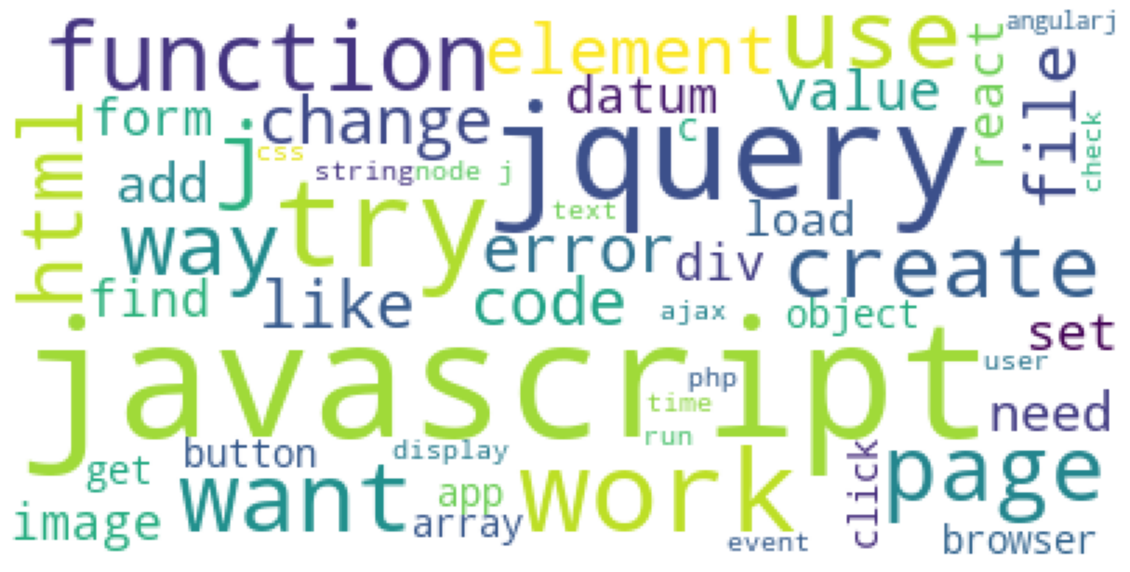

In [28]:
words_cloud(df_clean.loc[tag_is_in(df_clean, "javascript"), "Token_lemma"])

/opt/conda/lib/python3.7/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/conda/lib/python3.7/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/conda/lib/python3.7/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/conda/lib/python3.7/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is No

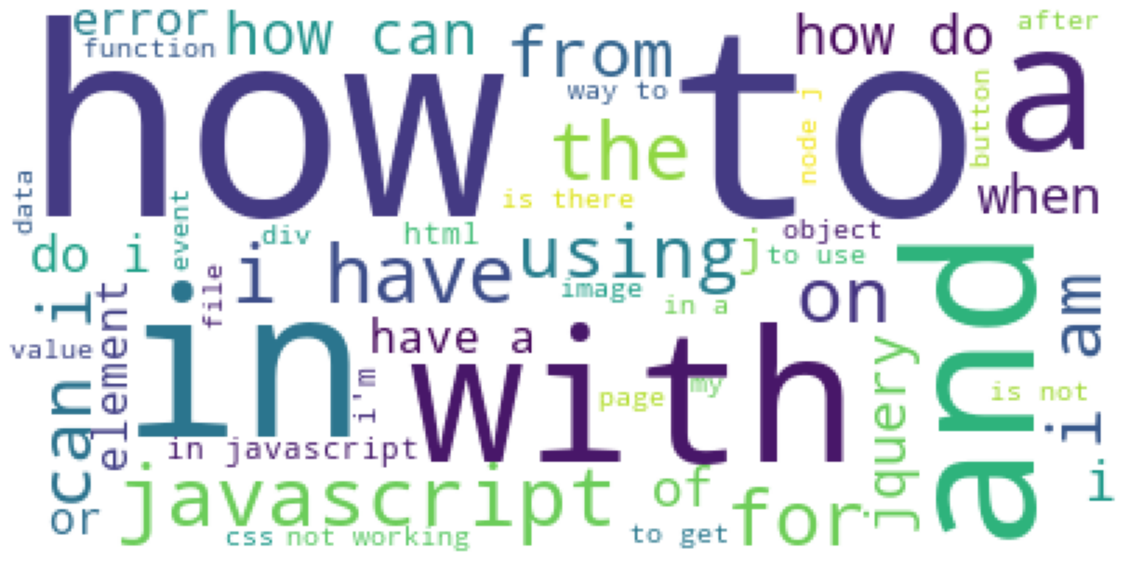

In [29]:
words_cloud(df_clean.loc[tag_is_in(df_clean, "javascript"), "Token_BERT"])

/opt/conda/lib/python3.7/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/conda/lib/python3.7/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/opt/conda/lib/python3.7/site-packages/wordcloud/wordcloud.py:520: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  Image.ROTATE_90)
/opt/conda/lib/python3.7/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/opt/conda/lib/python3.7/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTAT

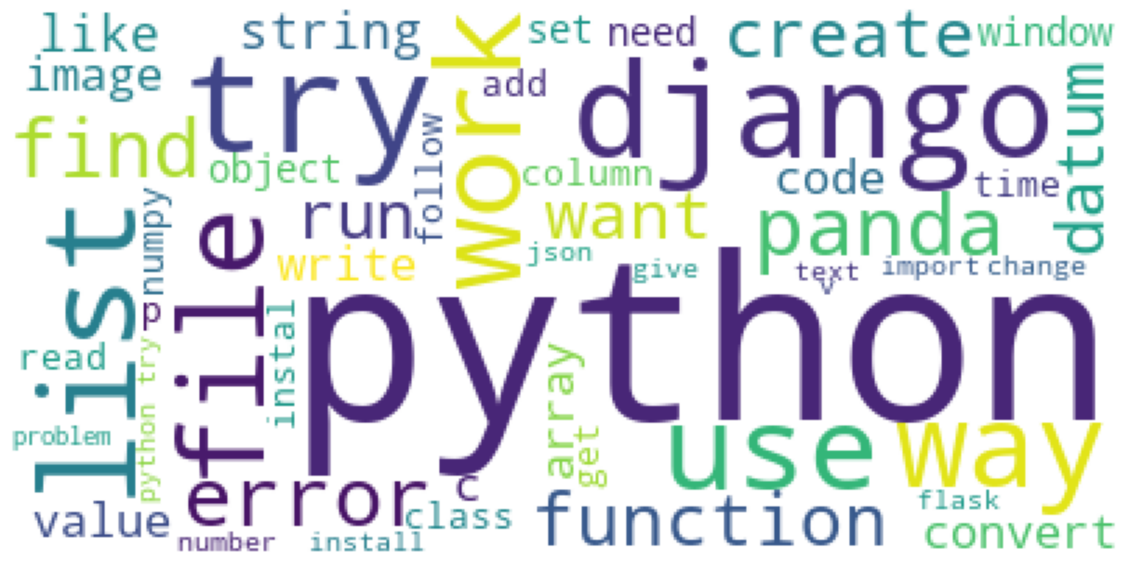

In [30]:
words_cloud(df_clean.loc[tag_is_in(df_clean, "python"), "Token_lemma"])

/opt/conda/lib/python3.7/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/conda/lib/python3.7/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/conda/lib/python3.7/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/opt/conda/lib/python3.7/site-packages/wordcloud/wordcloud.py:520: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  Image.ROTATE_90)
/opt/conda/lib/python3.7/site-packages/wordcloud/wordcloud.py:5

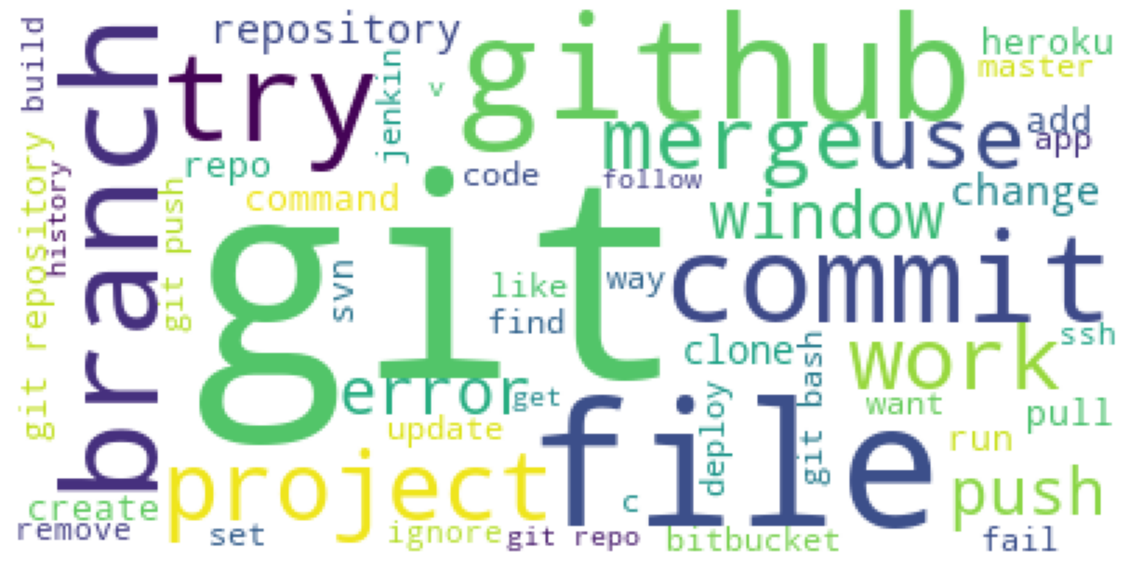

In [31]:
words_cloud(df_clean.loc[tag_is_in(df_clean, "git"), "Token_lemma"])

/opt/conda/lib/python3.7/site-packages/wordcloud/wordcloud.py:499: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = Image.ROTATE_90
/opt/conda/lib/python3.7/site-packages/wordcloud/wordcloud.py:520: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  Image.ROTATE_90)
/opt/conda/lib/python3.7/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/conda/lib/python3.7/site-packages/wordcloud/wordcloud.py:519: DeprecationWarning: ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.
  orientation = (Image.ROTATE_90 if orientation is None else
/opt/conda/lib/python3.7/site-packages/wordcloud/wordcloud.py:5

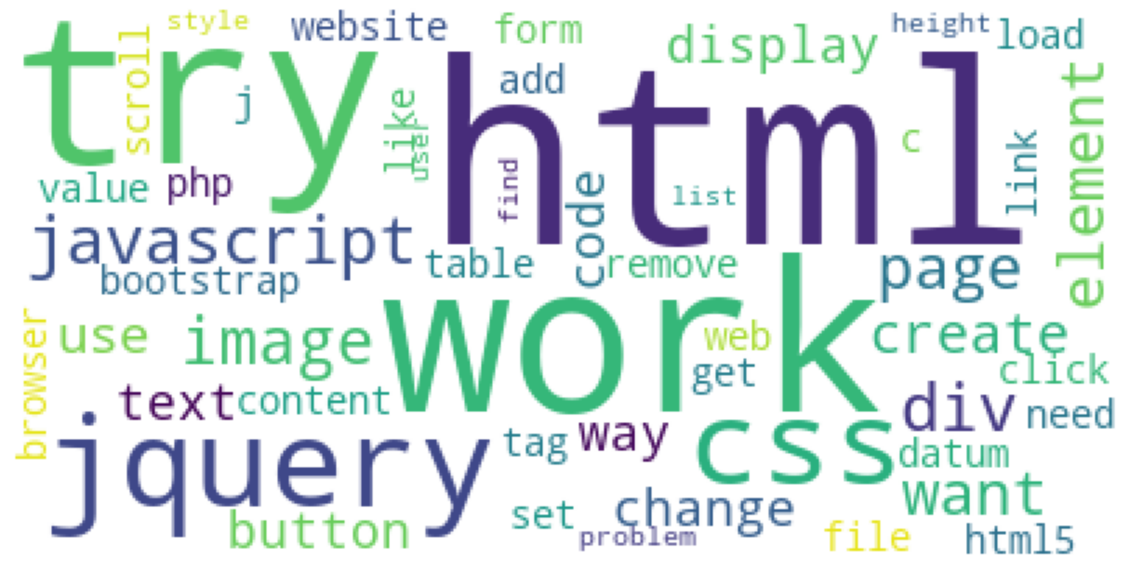

In [32]:
words_cloud(df_clean.loc[tag_is_in(df_clean, "html"), "Token_lemma"])

In [33]:
#java c# .. 

In [34]:
# %%time
# df["Title_clean"] = ""
# df["Code"] = ""
# df["Body_clean"] = ""
# start = time.time()


# def time_e():
#     return f"{time.time()-start:_.0f}s"


# bar = progressbar.ProgressBar(
#     maxval=len(df),
#     widgets=[
#         progressbar.Bar("=", "[", "]"),
#         " ",
#         progressbar.Percentage(),
#         " ",
#         time_e(),
#     ],
# )
# bar.start()
# for index, row in df.iterrows():
#     bar.update(index)
#     #     print(index, row["Title"])
#     title = nlp(row["Title"])
#     row["Title_clean"] = " ".join(
#         [
#             token.lemma_
#             for token in title
#             if token.pos_ in ["VERB", "NOUN", "PROPN", "ADP"] and not token.is_stop
#         ]
#     ).lower()
#     # print(row["Title_clean"])
#     soup = BeautifulSoup(row["Body"])
#     row["Code"] = " ".join([code.get_text() for code in soup.find_all("code")])
#     row["Body_clean"] = " ".join(
#         [
#             token.lemma_
#             for token in nlp(" ".join([p.get_text() for p in soup.find_all("p")]))
#             if token.pos_ in ["VERB", "NOUN", "PROPN", "ADP"] and not token.is_stop
#         ]
#     ).lower()
#     df.iloc[index] = row
# bar.finish()
# df[0:5][["Title", "Title_clean", "Code", "Body_clean"]]

In [35]:
df_clean.to_csv("/kaggle/working/stackoverflowCleanedV2.csv")

In [36]:
# from ipywidgets import interact


# @interact(i=(0, df.shape[0] - 1))
# def test_tr_print(i):
#     print(
#         f'***Title***{df["Title"][i]}\n{"*"*30}\n***Body***{df["Body"][i]}\n{"*"*30}\n***lemma***{df["Token_lemma"][i]}\n{"*"*30}\n***bert***{df["Token_BERT"][i]}\n{"*"*30}\n***Code***{df["Code"][i]}\n{"*"*30}\n{df.loc[i,0]} {df.loc[i,1]} {df.loc[i,2]} {df.loc[i,3]} {df.loc[i,4]}'
#     )

In [37]:
# test_tr_print(2)